<a href="https://colab.research.google.com/github/kei-ai/Colab/blob/main/%E6%A0%AA%E4%BE%A1%E5%8F%96%E5%BE%97%EF%BC%86Tensorflow_%E7%B4%8D%E5%93%81%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahoo_finance_api2
import sys
import csv
import os
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
import pandas as pd
import datetime as dt
import numpy as np
import time
import datetime
!pip install tensorflow
!pip install keras
!pip install pandas
import numpy as np 
np.random.seed(202)
import pandas as pd 
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import os.path
from keras.models import model_from_json

!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib


  Created wheel for yahoo-finance-api2: filename=yahoo_finance_api2-0.0.9-cp36-none-any.whl size=3690 sha256=ece10fa47d8de4b3c40a0f6100ae4bb732e1cdf726e0fa668f085210af1325bf
  Stored in directory: /root/.cache/pip/wheels/15/39/5b/85c9dfaaf940699ca6dadd79685eff20828edc4890197f552a
Successfully built yahoo-finance-api2
Selecting previously unselected package libta-lib0.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB

In [ ]:

def get_D1():
    global df
    global d
    my_share = share.Share(code + '.T')
    symbol_data = None

    try:
        symbol_data = my_share.get_historical(share.PERIOD_TYPE_YEAR, 20,
                                             share.FREQUENCY_TYPE_DAY, 1)
        time.sleep(2)
    except YahooFinanceError as e:
        print(e.message)
        sys.exit(1)

  #------------------------------------------
    #Dataframe
    df = pd.DataFrame(symbol_data)
    def convert_timestamp_to_date(timestamp):
        return dt.datetime.fromtimestamp(timestamp/1000.0).isoformat()
    lst = list(map(convert_timestamp_to_date, df['timestamp']))
    df.insert(1, 'date',lst)
    df['date'] = pd.to_datetime(df['date'])+datetime.timedelta(hours=9)
    df.drop(columns=['timestamp'], axis=1,inplace=True)#inplaceで上書き
   
    #df.drop(columns=['high'], axis=1,inplace=True)#inplaceで上書き
    #df.drop(columns=['low'], axis=1,inplace=True)#inplaceで上書き
    #df.drop(columns=['open'], axis=1,inplace=True)#inplaceで上書き
    df['volume']=df['volume']+1
    #0だとエラーのなるので+1

    df=df.dropna(how='any')
    d=df
    d.drop(columns=['high'], axis=1,inplace=True)
    d.drop(columns=['low'], axis=1,inplace=True)
    d.drop(columns=['open'], axis=1,inplace=True)
    d.drop(columns=['volume'], axis=1,inplace=True)
    

    df=tec(df).dropna(how='any')
    print(df)
    df=df.set_index('date')  
loss="mae"
optimizer="adam"
activ_func="linear"
output_size=1

dropout=0.01
neurons=100

f_log = '/content/drive/My Drive/Price/LSTM/log'
f_model = '/content/drive/My Drive/Price/LSTM/model'
os.makedirs('/content/drive/My Drive/Price/LSTM', exist_ok=True)
#使うインジケータ
def tec(X):
    close = np.array(X['close'])
    output = close.copy()
    cols = ['Original']


    # 単純移動平均(SMA: Simple Moving Average)
    output = np.c_[output, talib.SMA(close,timeperiod=21)]
    cols += ['SMA']


    # 指数移動平均(EMA: Exponential Moving Average)
    output = np.c_[output, talib.EMA(close,timeperiod=21)]
    cols += ['EMA']


    # ボリンジャー・バンド(Bollinger Bands)
    for arr in talib.BBANDS(close, timeperiod=15, nbdevup=2, nbdevdn=2, matype=0):
        output = np.c_[output, arr]
    cols += ['BB_up', 'BB_middle', 'BB_low']


    #RSI: Relative Strength Index
    output = np.c_[output, talib.RSI(close,timeperiod=21)]
    cols += ['RSI']


    # MACD: Moving Average Convergence/Divergence
    for arr in talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9):
        output = np.c_[output, arr]
    cols += ['MACD', 'MACD_signal', 'MACD_hist']


    data = pd.DataFrame(output, index=X.index, columns=cols)
    data=pd.concat([X,data],axis=1)
    data=data.drop(['Original'],axis=1)
    return data

#==============================================================================
def input():
    #①テンソル化
    global train_lstm_in
    global test_lstm_in
    global X_train
    global X_test
    global Loss
    get_D1()
    #パラメータ

    X_data = df
    test_idx_from = int(len(df)*3/4) #学習させるデータ数
    #学習用データ
    X_train = X_data

    #テスト用データ
    X_test  = X_data[-window_len-1:]

    train_lstm_in = []
    for i in range(len(X_train) - window_len):
        temp = X_train[i:(i + window_len)].copy()
        temp.iloc[:, :] = temp.iloc[:,:]  / temp.iloc[0, :] - 1
        train_lstm_in.append(temp)

    test_lstm_in = []
    for i in range(len(X_test) - window_len):
        temp = X_test[i:(i + window_len)].copy()
        temp.iloc[:, :] = temp.iloc[:, :]  / temp.iloc[0,:] - 1
        test_lstm_in.append(temp)

    train_lstm_in = [np.array(train_lstm_input) for train_lstm_input in train_lstm_in]
    train_lstm_in = np.array(train_lstm_in)
    
    test_lstm_in = [np.array(test_lstm_input) for test_lstm_input in test_lstm_in]
    test_lstm_in = np.array(test_lstm_in)

def output(): #上がるか下がるか
    global lstm_train_out
    global lstm_test_out

    up_down=X_train['close'][window_len:].values-X_train['close'][window_len-n:-n].values
    lstm_train_out = np.zeros_like(up_down)#価格が下がれば０
    lstm_train_out[up_down > 0] = 1 

    up_down=X_test['close'][window_len:].values-X_test['close'][window_len-n:-n].values
    lstm_test_out = np.zeros_like(up_down)#価格が下がれば０
    lstm_test_out[up_down > 0] = 1 
                  #上昇トレンドなら１、下降トレンドなら0

def output2(): #変動
    global lstm_train_out
    global lstm_test_out


    up_down=X_train['close'][window_len:].values-X_train['close'][window_len-n:-n].values
    lstm_train_out = up_down/X_train['close'][window_len:].values


    up_down=X_test['close'][window_len:].values-X_test['close'][window_len-n:-n].values
    lstm_test_out = up_down/X_test['close'][window_len:].values


def build_model():
    global model
    global MAE
    global score
    #②学習スタート
    model = Sequential()

    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model.fit(train_lstm_in, lstm_train_out, 
                            epochs= epoch, batch_size=1, verbose=2, shuffle=None)

    score = model.evaluate(test_lstm_in, lstm_test_out, verbose=0)
    MAE=score[0]
    print('Test score:', MAE)
    print('正答率:', score[1])
   
   
   
    #③学習モデル保存
    model_filename = '/cnn_mode_'+str(window_len)+'.json'
    model_yaml='/cnn_model_'+str(window_len)+'.yaml'
    weights_filename = '/cnn_model_weights_'+str(window_len)+'.hdf5'
                      #モデルファイル名

    print('save the architecture of a model')
    json_string = model.to_json()
    open(os.path.join(f_model,model_filename), 'w').write(json_string)
    yaml_string = model.to_yaml()
    open(os.path.join(f_model,), 'w').write(yaml_string)
    print('save weights')
    model.save_weights(os.path.join(f_model,weights_filename))
    #model.summary()


def predict(n):
    global df2,df4
    global v
    global p
    global pp
    output2()
    build_model()
    #use_saved_model(window_len,epoch)

    predict = []
    for i in range(1,window_len):
            temp = X_test[-i-window_len:-i].copy()
            temp.iloc[:, :] = temp.iloc[:, :]  / temp.iloc[0, :] - 1
            predict.append(temp)

    predict = [np.array(train_lstm_input) for train_lstm_input in predict]
    predict = np.array(train_lstm_in)
    #print('過去',window_len,'日間のデータをもとに予測した',n,'日後の変動率は',model.predict(predict)[-n-1:-1]*100,'%です。')
    v=model.predict(predict)
    df2 = pd.DataFrame(v[-n-1:-1])
    df2.insert(1,'close',df2)
    df2.drop(columns=[0], axis=1,inplace=True)
    df4=pd.concat([df3,df2],axis=0)
    f=df4[-2*n:-n]
    for i in range(0,n):
      df4.iloc[-n+i, :] = f.iloc[-n+i, :]  *(1+ df4.iloc[-n+i, :] )
      df4=df4.rename(index={i: 1001+i})
    #df2= df2.rename(index={0: n})

    #Loss= pd.DataFrame({code: [MAE]},
                  #index=[k+10])






 #過去X日間から  
            #n日後の上下を予想
epoch=20
count = 1
error=0

csvfile = "/content/drive/My Drive/Price/銘柄2.csv"
with open(csvfile, "r") as f:
    total = csv.reader(f)
    for number in total:
        
        code = str("".join(number))
        print("ループ回数: " + str(count))
        print(code)
        count=count+1
        df6=pd.DataFrame()
        try:    
            for m in range(1,4):
              window_len=20*m
              input()
              df4=pd.DataFrame()
              df5=pd.DataFrame()
              
              df3= d[-20-1:-1]
              df3.drop(columns=['date'], axis=1,inplace=True)
              for n in range(1,6):
                predict(n)
                df5=pd.concat([df5,df4],axis=1)
              df6=pd.concat([df6,df5],axis=1)
            
            df6.to_csv("/content/drive/My Drive/Price/DL_"+code+".csv")
        except:
            print("Error")
            error=error+1
            print("Error回数: " + str(error))
            pass



ループ回数: 1
3994
                   date   close          SMA  ...       MACD  MACD_signal  MACD_hist
33  2017-11-15 09:00:00  1477.5  1514.023810  ...  -5.884713    -5.267630  -0.617083
34  2017-11-16 09:00:00  1489.0  1513.833333  ...  -7.104850    -5.635074  -1.469776
35  2017-11-17 09:00:00  1522.5  1516.666667  ...  -5.307466    -5.569552   0.262086
36  2017-11-20 09:00:00  1527.5  1517.619048  ...  -3.439916    -5.143625   1.703709
37  2017-11-21 09:00:00  1525.0  1519.095238  ...  -2.136964    -4.542293   2.405329
..                  ...     ...          ...  ...        ...          ...        ...
787 2020-11-30 09:00:00  4720.0  4686.666667  ...  11.473962    50.075913 -38.601951
788 2020-12-01 09:00:00  4865.0  4693.571429  ...  32.220030    46.504737 -14.284707
789 2020-12-02 09:00:00  4800.0  4697.619048  ...  42.921706    45.788131  -2.866424
790 2020-12-03 09:00:00  4835.0  4717.380952  ...  53.609097    47.352324   6.256774
791 2020-12-04 11:35:01  4665.0  4715.000000  ...  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
739/739 - 4s - loss: 0.1480 - accuracy: 0.0501
Epoch 2/20
739/739 - 4s - loss: 0.0860 - accuracy: 0.0474
Epoch 3/20
739/739 - 4s - loss: 0.0586 - accuracy: 0.0501
Epoch 4/20
739/739 - 4s - loss: 0.0492 - accuracy: 0.0501
Epoch 5/20
739/739 - 4s - loss: 0.0445 - accuracy: 0.0501
Epoch 6/20
739/739 - 4s - loss: 0.0426 - accuracy: 0.0501
Epoch 7/20
739/739 - 4s - loss: 0.0348 - accuracy: 0.0501
Epoch 8/20
739/739 - 4s - loss: 0.0342 - accuracy: 0.0501
Epoch 9/20
739/739 - 4s - loss: 0.0333 - accuracy: 0.0501
Epoch 10/20
739/739 - 4s - loss: 0.0323 - accuracy: 0.0501
Epoch 11/20
739/739 - 4s - loss: 0.0302 - accuracy: 0.0501
Epoch 12/20
739/739 - 4s - loss: 0.0296 - accuracy: 0.0501
Epoch 13/20
739/739 - 4s - loss: 0.0288 - accuracy: 0.0501
Epoch 14/20
739/739 - 4s - loss: 0.0292 - accuracy: 0.0501
Epoch 15/20
739/739 - 4s - loss: 0.0289 - accuracy: 0.0501
Epoch 16/20
739/739 - 4s - loss: 0.0290 - accuracy: 0.0501
Epoch 17/20
739/739 - 4s - loss: 0.0283 - accuracy: 0.0501
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
719/719 - 7s - loss: 0.1527 - accuracy: 0.0417
Epoch 2/20
719/719 - 7s - loss: 0.1019 - accuracy: 0.0417
Epoch 3/20
719/719 - 7s - loss: 0.0770 - accuracy: 0.0417
Epoch 4/20
719/719 - 7s - loss: 0.0582 - accuracy: 0.0417
Epoch 5/20
719/719 - 7s - loss: 0.0527 - accuracy: 0.0417
Epoch 6/20
719/719 - 7s - loss: 0.0441 - accuracy: 0.0417
Epoch 7/20
719/719 - 7s - loss: 0.0409 - accuracy: 0.0417
Epoch 8/20
719/719 - 7s - loss: 0.0388 - accuracy: 0.0417
Epoch 9/20
719/719 - 7s - loss: 0.0379 - accuracy: 0.0417
Epoch 10/20
719/719 - 7s - loss: 0.0350 - accuracy: 0.0417
Epoch 11/20
719/719 - 7s - loss: 0.0320 - accuracy: 0.0417
Epoch 12/20
719/719 - 7s - loss: 0.0305 - accuracy: 0.0417
Epoch 13/20
719/719 - 7s - loss: 0.0305 - accuracy: 0.0417
Epoch 14/20
719/719 - 7s - loss: 0.0307 - accuracy: 0.0417
Epoch 15/20
719/719 - 7s - loss: 0.0304 - accuracy: 0.0417
Epoch 16/20
719/719 - 7s - loss: 0.0300 - accuracy: 0.0417
Epoch 17/20
719/719 - 7s - loss: 0.0293 - accuracy: 0.0417
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
699/699 - 9s - loss: 0.1162 - accuracy: 0.0358
Epoch 2/20
699/699 - 9s - loss: 0.0829 - accuracy: 0.0372
Epoch 3/20
699/699 - 9s - loss: 0.0635 - accuracy: 0.0372
Epoch 4/20
699/699 - 9s - loss: 0.0545 - accuracy: 0.0372
Epoch 5/20
699/699 - 9s - loss: 0.0486 - accuracy: 0.0372
Epoch 6/20
699/699 - 9s - loss: 0.0398 - accuracy: 0.0372
Epoch 7/20
699/699 - 9s - loss: 0.0377 - accuracy: 0.0372
Epoch 8/20
699/699 - 9s - loss: 0.0369 - accuracy: 0.0372
Epoch 9/20
699/699 - 9s - loss: 0.0356 - accuracy: 0.0372
Epoch 10/20
699/699 - 9s - loss: 0.0342 - accuracy: 0.0372
Epoch 11/20
699/699 - 9s - loss: 0.0324 - accuracy: 0.0372
Epoch 12/20
699/699 - 9s - loss: 0.0314 - accuracy: 0.0372
Epoch 13/20
699/699 - 9s - loss: 0.0320 - accuracy: 0.0372
Epoch 14/20
699/699 - 9s - loss: 0.0309 - accuracy: 0.0372
Epoch 15/20
699/699 - 9s - loss: 0.0298 - accuracy: 0.0372
Epoch 16/20
699/699 - 9s - loss: 0.0299 - accuracy: 0.0372
Epoch 17/20
699/699 - 9s - loss: 0.0298 - accuracy: 0.0372
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
181/181 - 1s - loss: 0.1863 - accuracy: 0.0387
Epoch 2/20
181/181 - 1s - loss: 0.1732 - accuracy: 0.0387
Epoch 3/20
181/181 - 1s - loss: 0.1346 - accuracy: 0.0387
Epoch 4/20
181/181 - 1s - loss: 0.0920 - accuracy: 0.0387
Epoch 5/20
181/181 - 1s - loss: 0.0909 - accuracy: 0.0387
Epoch 6/20
181/181 - 1s - loss: 0.0627 - accuracy: 0.0387
Epoch 7/20
181/181 - 1s - loss: 0.0725 - accuracy: 0.0387
Epoch 8/20
181/181 - 1s - loss: 0.0628 - accuracy: 0.0387
Epoch 9/20
181/181 - 1s - loss: 0.0882 - accuracy: 0.0387
Epoch 10/20
181/181 - 1s - loss: 0.0746 - accuracy: 0.0387
Epoch 11/20
181/181 - 1s - loss: 0.0594 - accuracy: 0.0387
Epoch 12/20
181/181 - 1s - loss: 0.0558 - accuracy: 0.0387
Epoch 13/20
181/181 - 1s - loss: 0.0488 - accuracy: 0.0387
Epoch 14/20
181/181 - 1s - loss: 0.0512 - accuracy: 0.0387
Epoch 15/20
181/181 - 1s - loss: 0.0491 - accuracy: 0.0387
Epoch 16/20
181/181 - 1s - loss: 0.0493 - accuracy: 0.0387
Epoch 17/20
181/181 - 1s - loss: 0.0437 - accuracy: 0.0387
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


161/161 - 2s - loss: 0.1899 - accuracy: 0.0435
Epoch 2/20
161/161 - 2s - loss: 0.2142 - accuracy: 0.0435
Epoch 3/20
161/161 - 2s - loss: 0.1426 - accuracy: 0.0435
Epoch 4/20
161/161 - 2s - loss: 0.1039 - accuracy: 0.0435
Epoch 5/20
161/161 - 1s - loss: 0.1046 - accuracy: 0.0435
Epoch 6/20
161/161 - 1s - loss: 0.1181 - accuracy: 0.0435
Epoch 7/20
161/161 - 1s - loss: 0.0714 - accuracy: 0.0435
Epoch 8/20
161/161 - 2s - loss: 0.0698 - accuracy: 0.0435
Epoch 9/20
161/161 - 2s - loss: 0.0646 - accuracy: 0.0435
Epoch 10/20
161/161 - 2s - loss: 0.0685 - accuracy: 0.0435
Epoch 11/20
161/161 - 1s - loss: 0.0694 - accuracy: 0.0435
Epoch 12/20
161/161 - 2s - loss: 0.0490 - accuracy: 0.0435
Epoch 13/20
161/161 - 2s - loss: 0.0650 - accuracy: 0.0435
Epoch 14/20
161/161 - 1s - loss: 0.0634 - accuracy: 0.0435
Epoch 15/20
161/161 - 1s - loss: 0.0547 - accuracy: 0.0435
Epoch 16/20
161/161 - 1s - loss: 0.0467 - accuracy: 0.0435
Epoch 17/20
161/161 - 2s - loss: 0.0488 - accuracy: 0.0435
Epoch 18/20
161/1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/20
141/141 - 2s - loss: 0.2496 - accuracy: 0.0355
Epoch 2/20
141/141 - 2s - loss: 0.2230 - accuracy: 0.0355
Epoch 3/20
141/141 - 2s - loss: 0.1134 - accuracy: 0.0284
Epoch 4/20
141/141 - 2s - loss: 0.1671 - accuracy: 0.0213
Epoch 5/20
141/141 - 2s - loss: 0.0902 - accuracy: 0.0355
Epoch 6/20
141/141 - 2s - loss: 0.1069 - accuracy: 0.0284
Epoch 7/20
141/141 - 2s - loss: 0.0822 - accuracy: 0.0355
Epoch 8/20
141/141 - 2s - loss: 0.0780 - accuracy: 0.0355
Epoch 9/20
141/141 - 2s - loss: 0.0618 - accuracy: 0.0355
Epoch 10/20
141/141 - 2s - loss: 0.0612 - accuracy: 0.0355
Epoch 11/20
141/141 - 2s - loss: 0.0573 - accuracy: 0.0355
Epoch 12/20
141/141 - 2s - loss: 0.0605 - accuracy: 0.0355
Epoch 13/20
141/141 - 2s - loss: 0.0622 - accuracy: 0.0355
Epoch 14/20
141/141 - 2s - loss: 0.0572 - accuracy: 0.0355
Epoch 15/20
141/141 - 2s - loss: 0.0510 - accuracy: 0.0355
Epoch 16/20
141/141 - 2s - loss: 0.0428 - accuracy: 0.0355
Epoch 17/20
141/141 - 2s - loss: 0.0401 - accuracy: 0.0355
Epoch 

In [ ]:
df6


,close,close,close,close,close,close,close,close,close,close,close,close,close,close,close
213,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
214,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
215,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000
216,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000,8360.000000
217,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000,7870.000000
218,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
219,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000
220,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000
221,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000
222,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000


In [ ]:
f=df4[-2*n:-n]
f.iloc[-n, :]
df4.iloc[-n, :]

close   -0.999996
Name: 0, dtype: float64

In [ ]:

df4

,close
213,9000.000000
214,9000.000000
215,9040.000000
216,8360.000000
217,7870.000000
218,8500.000000
219,8410.000000
220,8150.000000
221,7820.000000
222,8230.000000


In [ ]:
df4["close"][-n:]=df4["close"][-2*n:-n]*df4["close"][-n:]
df4

AttributeError: ignored

In [ ]:
df4["close"][-n:]

0   -0.045676
1   -0.057127
Name: close, dtype: float64

In [ ]:
df4=pd.concat([df3,df2],axis=0)
df5=pd.DataFrame()
df5=pd.concat([df5,df4],axis=1)
df5=pd.concat([df5,df3],axis=1)
df5

,close,close
0,7.819455,NaN
1,7.495852,NaN
213,9000.000000,9000.0
214,9000.000000,9000.0
215,9040.000000,9040.0
216,8360.000000,8360.0
217,7870.000000,7870.0
218,8500.000000,8500.0
219,8410.000000,8410.0
220,8150.000000,8150.0


In [ ]:
model.predict(predict)

ValueError: ignored

In [ ]:
code

'4478'

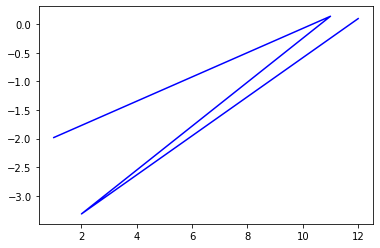

In [ ]:
 import matplotlib.pyplot as plt

plt.plot(df4.index, df4['3994'], label='close', color='blue')